In [1]:
%reset

In [1]:
from data_retriever import DataRetriever
from pre_processing import PreProcessing
from scalers.min_max import MinMax
from regressors.lstm_regressor import LSTMRegressor
from regressors.esn_regressor import ESNRegressor
from decomposers.wavelet_transform import WaveletDecomposition
from decomposers.hilbert_huang     import EMDDecomposition
from chm.chm import CascadeHierarquicalModel
import config
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from regressors.ann_regressor import ANNRegressor
from sklearn.model_selection import train_test_split


In [2]:
from typing                 import List
from chm.level              import CHMLevel
from chm.stages             import CHMStage
from decomposers.decomposer import BaseDecomposer
from regressors.regressor   import BaseRegressor
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from copy import copy
from pandas.core.frame import DataFrame
from copy import deepcopy
import seaborn as sns
from matplotlib import pyplot as plt
import os
from math import floor

class CascadeHierarquicalModel():
    """
    Cascade Hierarquical Model used to extract context from timeseries and predict non stationary timeseries

    parameters : BaseRegressor    (Instanciated base regressor used to extract context)
                 BaseRegressor    (Instanciated base regressor used to join context created from the stages)
                 SeriesDecomposer (decomposition used to extract frequency from time series)
                 int              (number of levels in the hierarquical model)
                 int              (number of stages in the hierarquical model)
                 bool             (use frequency extracted from time series as a feature)
    
    """
    
    def __init__(self,  ds:DataFrame                      ,
                        # x_cols:List[str]                  ,
                        y_cols:str                        ,
                        context_regressor:BaseRegressor   , 
                        stage_regressor:BaseRegressor     ,
                        decomposer:BaseDecomposer         ,
                        dec_cols:List[str]                ,
                        num_stages:int=1                  ,
                        use_frequency:bool=False          ,
                        verbose=True,
                        epochs= 150
                ):
        self._ds                                   = ds
        # self._x_cols                             = x_cols
        self._y_cols                               = y_cols
        self._context_regressor                    = context_regressor
        self._stage_regressor                      = stage_regressor
        self._dec                                  = decomposer
        self._dec_cols                             = dec_cols
        self._num_stages                           = num_stages
        self._use_frequency                        = use_frequency
        self._list_stages_bottom_up:List[CHMStage] = list()
        self._list_levels_frequency:List[CHMLevel] = list()
        self._verbose                              = verbose
        self._n_inputs                             = 7
        self._epochs                               = epochs
        
        # Obtaining the biggest decomposition
        self._max_wave = len(self._dec.dict_waves[y_cols])
        
    def train_context_extraction(self) -> None:
        self._set_bottom_up_block()
        self._set_frequency_predictor_block()
        self._train_frequency_block()
        self._set_top_down_block()
        self._train_top_down_block()
    
    def predict(self, X:DataFrame) -> List[float]:
        self._predict_bottom_up(X)
        self._predict_frequencies(X)
        return self._predict_top_down()


    def _predict_bottom_up(self, X:DataFrame):
        if(self._verbose):
            print('============================================================')
            print('Predicting bottom up block ...')

        # Flatting subwave column name dictionary
        sub_waves = list() 
        for i in self._dec.dict_waves.keys():
            sub_waves = sub_waves + self._dec.dict_waves[i]

        # For each stage
        for stage, stage_num in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            max_len = 0

            # Copying temporary dict of waves
            temp_dec_dict = deepcopy(self._dec.dict_waves)

            if self._use_frequency:
                # Copying temporary dict of frequencies
                temp_freq_dict = deepcopy(self._dec.dict_freq)

            # List of levels for this stage
            temp_level_list:List[CHMLevel] = list()

            # Set last level var
            last_level:CHMLevel = None

            # For each level in the current stage
            for level, level_num in zip(stage._level_list, range(len(stage._level_list))):
                if(self._verbose):
                    print('Creating Context > ', 'Level > ', level_num, ' of Stage > ', stage_num)
                
                temp_ds = X.copy(deep=True)

                # Creating dataset for this level
                for wave in temp_dec_dict.keys():

                    # Initiating sintetized column of wave
                    temp_ds[wave + '_sintetized'] = 0   

                    # For each decomposed subwave of current wave
                    for col in temp_dec_dict[wave]:
                        temp_ds[wave + '_sintetized'] = temp_ds[wave + '_sintetized'] + temp_ds[col]

                if self._use_frequency:
                    # For each frequency subwave of current wave
                    for col in temp_freq_dict.keys():
                        temp_ds[wave + '_frequency'] = temp_ds[temp_freq_dict[col][0]]

                # Leaving only sintetized columns
                # Dropping used subwave
                temp_ds.drop(sub_waves, axis=1, inplace=True)
                
                # Dropping original waves
                temp_ds.drop(self._dec_cols, axis=1, inplace=True)
                ##

                # List of features of current level (X Cols)
                curr_feat_cols = temp_ds.columns.difference(['Date'])

                # Saving Y from dataset
                temp_ds_y = temp_ds[self._y_cols + '_sintetized']
                
                # Transforming X Cols features to 3 dimensional tensor
                temp_ds_x  = timeseries_dataset_from_array(data=temp_ds[curr_feat_cols].to_numpy(), 
                                                                targets=None, 
                                                                sequence_length=self._n_inputs,
                                                                sequence_stride=1,
                                                                batch_size=len(temp_ds[curr_feat_cols].to_numpy()))

                # Casting Tensor to list
                temp_ds_x = next(temp_ds_x.as_numpy_iterator())
                temp_ds_x = temp_ds_x.tolist()

                curr_n_features = len(curr_feat_cols)

                # Adding prediction from last level if not first level
                if last_level is not None:
                    curr_n_features += 1
                    for line, gen_ctxt in zip(temp_ds_x, last_level.generated_prediction.ravel().tolist()):
                        for line_in_line in line:
                            line_in_line.append(gen_ctxt) 
                
                # Creating context for level
                level.create_prediction2(temp_ds_x[:-1])
    
                last_level = level

                for k in temp_dec_dict.keys():
                    if len(temp_dec_dict[k]) > 1:
                        temp_dec_dict[k].pop()

                if self._use_frequency:
                    for k in temp_freq_dict.keys():
                        if len(temp_freq_dict[k]) > 1:
                            temp_freq_dict[k] = temp_freq_dict[k][1:]

    def _predict_frequencies(self, X:DataFrame) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting up frequency predictor block ...')

        sub_waves = list() 
        for i in self._dec.dict_waves.keys():
            sub_waves = sub_waves + self._dec.dict_waves[i]
        
        # For each level of frequency of target
        for level, level_num in zip(self._list_levels_frequency, range(len(self._list_levels_frequency))):
            temp_ds = X.copy(deep=True)

            if(self._verbose):
                print('Setting up predictor of ', self._y_cols, ' frequency > ', level_num)

            # Creating dataset for this level
            cols = list()
            for wave in self._dec.dict_waves.keys():
                max_len = len(self._dec.dict_waves[wave])
                if level_num >= max_len:
                    cols.append(self._dec.dict_waves[wave][max_len-1])
                else:
                    cols.append(self._dec.dict_waves[wave][level_num])

            drop_cols = list(filter(lambda x: x not in cols, sub_waves))
            
            # Dropping unused frequency waves
            temp_ds.drop(drop_cols, axis=1, inplace=True)
            
            # Dropping original waves
            temp_ds.drop(self._dec_cols, axis=1, inplace=True)

            # List of features of current level
            curr_feat_cols = temp_ds.columns.difference(['Date'])

            level.create_prediction(temp_ds[curr_feat_cols])

    def _predict_top_down(self) -> List[float]:
        if(self._verbose):
            print('============================================================')
            print('Setting top-down regressors ...')
        for stage, stage_number in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            stage_ds = pd.DataFrame()
            if self._verbose:
                print('Creating topdown regressor of Stage > ', stage_number)

            for level, level_number in zip(stage._level_list, range(len(stage._level_list))):
                stage_ds['context_level_' + str(level_number)] = level.generated_prediction.ravel()
            
            for frequency, frequency_number in zip(self._list_levels_frequency, range(len(self._list_levels_frequency))):
                stage_ds['frequency_level_' + str(frequency_number)] = frequency.generated_prediction.ravel()

            top_down_ds = pd.DataFrame()
            for level in range(len(stage._level_list)):
                top_down_ds['input_level_' + str(level)] = stage_ds['context_level_' + str(level)]
                for frequency_level, frequency_reversed in zip(range(len(stage._level_list)), reversed(range(len(stage._level_list)))):
                    if frequency_level < level :
                        top_down_ds['input_level_' + str(level)] = top_down_ds['input_level_' + str(level)] + stage_ds['frequency_level_' + str(frequency_reversed)]
            
            curr_feat_cols = top_down_ds.columns.difference([self._y_cols])

            return stage._regressor.predict(top_down_ds[curr_feat_cols])


    def _train_top_down_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Training top-down regressors ...')
        for stage, stage_number in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            stage._regressor.fit(stage._regressor.ds[stage._regressor.x_cols], 
                                stage._regressor.ds[stage._regressor.y_cols])
            if self._verbose:
                print('Training topdown regressor of Stage > ', stage_number)

    def _set_top_down_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting top-down regressors ...')
        for stage, stage_number in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            stage_ds = pd.DataFrame()
            if self._verbose:
                print('Creating topdown regressor of Stage > ', stage_number)

            for level, level_number in zip(stage._level_list, range(len(stage._level_list))):
                stage_ds['context_level_' + str(level_number)] = level.gerenerated_context.ravel()[-stage._max_level_context_len:]
            
            for frequency, frequency_number in zip(self._dec.dict_waves[self._y_cols], range(len(self._dec.dict_waves[self._y_cols]))):
                stage_ds['frequency_level_' + str(frequency_number)] = self._ds[frequency].to_list()[-stage._max_level_context_len:]

            top_down_ds = pd.DataFrame()
            for level in range(len(stage._level_list)):
                top_down_ds['input_level_' + str(level)] = stage_ds['context_level_' + str(level)]
                for frequency_level, frequency_reversed in zip(range(len(stage._level_list)), reversed(range(len(stage._level_list)))):
                    if frequency_level < level :
                        top_down_ds['input_level_' + str(level)] = top_down_ds['input_level_' + str(level)] + stage_ds['frequency_level_' + str(frequency_reversed)]
            
            top_down_ds[self._y_cols] = self._ds[self._y_cols].to_list()[-stage._max_level_context_len:]
            curr_feat_cols = top_down_ds.columns.difference([self._y_cols])
    
            stage._regressor = self._stage_regressor(
                                                        ds=top_down_ds, 
                                                        x_cols=curr_feat_cols, 
                                                        y_cols=self._y_cols, 
                                                        epochs=self._epochs
                                                    )
        

    def _set_bottom_up_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting up bottom up block ...')

        # Flatting subwave column name dictionary
        sub_waves = list() 
        for i in self._dec.dict_waves.keys():
            sub_waves = sub_waves + self._dec.dict_waves[i]

        # For each stage
        for stage in range(self._num_stages):
            max_len = 0

            # Copying temporary dict of waves
            temp_dec_dict = deepcopy(self._dec.dict_waves)

            if self._use_frequency:
                # Copying temporary dict of frequencies
                temp_freq_dict = deepcopy(self._dec.dict_freq)

            # List of levels for this stage
            temp_level_list:List[CHMLevel] = list()

            # Set last level var
            last_level:CHMLevel = None

            # For each level in the current stage
            for level in range(self._max_wave):
                if(self._verbose):
                    print('Creating Context > ', 'Level > ', level, ' of Stage > ', stage)
                
                temp_ds = self._ds.copy(deep=True)

                # Creating dataset for this level
                for wave in temp_dec_dict.keys():

                    # Initiating sintetized column of wave
                    temp_ds[wave + '_sintetized'] = 0   

                    # For each decomposed subwave of current wave
                    for col in temp_dec_dict[wave]:
                        temp_ds[wave + '_sintetized'] = temp_ds[wave + '_sintetized'] + temp_ds[col]

                if self._use_frequency:
                    # For each frequency subwave of current wave
                    for col in temp_freq_dict.keys():
                        temp_ds[wave + '_frequency'] = temp_ds[col[0]]

                # Leaving only sintetized columns
                # Dropping used subwave
                temp_ds.drop(sub_waves, axis=1, inplace=True)
                
                # Dropping original waves
                temp_ds.drop(self._dec_cols, axis=1, inplace=True)
                ##

                # List of features of current level (X Cols)
                curr_feat_cols = temp_ds.columns.difference(['Date'])

                # Saving Y from dataset
                temp_ds_y = temp_ds[self._y_cols + '_sintetized']
                
                # Transforming X Cols features to 3 dimensional tensor
                temp_ds_x  = timeseries_dataset_from_array(data=temp_ds[curr_feat_cols].to_numpy(), 
                                                                targets=None, 
                                                                sequence_length=self._n_inputs,
                                                                sequence_stride=1,
                                                                batch_size=len(temp_ds[curr_feat_cols].to_numpy()))

                # Casting Tensor to list
                temp_ds_x = next(temp_ds_x.as_numpy_iterator())
                temp_ds_x = temp_ds_x.tolist()

                curr_n_features = len(curr_feat_cols)

                # Adding prediction from last level if not first level
                if last_level is not None:
                    curr_n_features += 1
                    for line, gen_ctxt in zip(temp_ds_x, last_level.gerenerated_context.ravel().tolist()):
                        for line_in_line in line:
                            line_in_line.append(gen_ctxt) 

                
                # Instantiating CHM Level
                temp_level = CHMLevel(self._context_regressor(
                                                                n_inputs=self._n_inputs, 
                                                                n_features=curr_n_features, 
                                                                epochs=self._epochs
                                                             )
                                        )

                # Training Level # Ignoring last sequence of features
                temp_level.train2(temp_ds_x[:-1], temp_ds_y[self._n_inputs:].to_list())

                # Creating context for level
                temp_level.create_context2(temp_ds_x)

                # Appending level to list of levels of stage
                temp_level_list.append(temp_level)

                last_level = temp_level

                max_len = len(temp_level.gerenerated_context)

                for k in temp_dec_dict.keys():
                    if len(temp_dec_dict[k]) > 1:
                        temp_dec_dict[k].pop()

                if self._use_frequency:
                    for k in temp_freq_dict.keys():
                        if len(temp_freq_dict[k]) > 1:
                            temp_freq_dict[k] = temp_freq_dict[k][1:]
                    

            self._list_stages_bottom_up.append(CHMStage(temp_level_list, None, max_len))

    def _train_frequency_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Training frequencies regressors ...')
        for level, level_number in zip(self._list_levels_frequency, range(len(self._list_levels_frequency))):
            if self._verbose:
                print('Creating Context > ', 'Level > ', level_number, ', of Frequency Block')  
            level.train()
            # Creating context for level
            level.create_context(level._regressor.ds[level._regressor.x_cols])


    def _set_frequency_predictor_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting up frequency predictor block ...')

        sub_waves = list() 
        for i in self._dec.dict_waves.keys():
            sub_waves = sub_waves + self._dec.dict_waves[i]
        
        # For each level of frequency of target
        for level in range(self._max_wave):
            temp_ds = self._ds.copy(deep=True)

            if(self._verbose):
                print('Setting up predictor of ', self._y_cols, ' frequency > ', level)

            # Creating dataset for this level
            cols = list()
            for wave in self._dec.dict_waves.keys():
                max_len = len(self._dec.dict_waves[wave])
                if level >= max_len:
                    cols.append(self._dec.dict_waves[wave][max_len-1])
                else:
                    cols.append(self._dec.dict_waves[wave][level])

            drop_cols = list(filter(lambda x: x not in cols, sub_waves))
            
            # Dropping unused frequency waves
            temp_ds.drop(drop_cols, axis=1, inplace=True)
            
            # Dropping original waves
            temp_ds.drop(self._dec_cols, axis=1, inplace=True)

            # List of features of current level
            curr_feat_cols = temp_ds.columns.difference(['Date'])

            # Instantiating CHM Level
            temp_level = CHMLevel(self._context_regressor(
                                                            ds=temp_ds.copy(deep=True), 
                                                            x_cols=curr_feat_cols, 
                                                            y_cols=self._dec.dict_waves[y_cols][level], 
                                                            n_inputs=self._n_inputs, 
                                                            n_features=len(curr_feat_cols), 
                                                            epochs=self._epochs
                                                            )
                                    )

            self._list_levels_frequency.append(temp_level)

    def _print_bottom_up_series(self, show_picture=False, save_picture=True):
        sns.set_style("whitegrid")
        index_col = 'Date'
        if(self._verbose):
            print('============================================================')
            print('Printing bottom up block ...')

        # Flatting subwave column name dictionary
        sub_waves = list() 
        for i in self._dec.dict_waves.keys():
            sub_waves = sub_waves + self._dec.dict_waves[i]

        # For each stage
        for stage in range(self._num_stages):

            # Copying temporary dict of waves
            temp_dec_dict = deepcopy(self._dec.dict_waves)

            # For each level in the current stage
            for level in range(self._max_wave):
                if(self._verbose):
                    print('Printing series of input for > ', 'Level > ', level, ' of Stage > ', stage)
                
                temp_ds = self._ds.copy(deep=True)

                # Creating dataset for this level
                for wave in temp_dec_dict.keys():

                    # Initiating sintetized column of wave
                    temp_ds[wave + '_sintetized'] = 0   

                    # For each decomposed subwave of current wave
                    for col in temp_dec_dict[wave]:
                        temp_ds[wave + '_sintetized'] = temp_ds[wave + '_sintetized'] + temp_ds[col]

                # Leaving only sintetized columns
                # Dropping used subwave
                temp_ds.drop(sub_waves, axis=1, inplace=True)
                
                # Dropping original waves
                temp_ds.drop(self._dec_cols, axis=1, inplace=True)
                ##

                # List of features of current level (X Cols)
                curr_feat_cols = temp_ds.columns.difference(['Date'])
                
                for col in temp_ds[curr_feat_cols].columns:
                        

                    #Plotting Y
                    plt.plot(temp_ds[col], label=col)

                    #Adding legends to plot
                    plt.legend()

                    #Setting to show only n of dates on X-Axis
                    n = 30
                    num_dates = np.arange(0, len(temp_ds), n)
                    plt.xticks(num_dates, [(temp_ds[index_col][i]).strftime('%Y-%m-%d') for i in num_dates], rotation='vertical')

                    if save_picture:
                        folder = '../figs/CHM/bottom_up_block/stage/' + str(stage) + '/level' + str(level) + '/' 
                        if not os.path.exists(folder):
                            os.makedirs(folder)

                        plt.savefig(folder + col + '.png')
                    
                    if show_picture:
                        plt.show()

                    plt.clf()

                for k in temp_dec_dict.keys():
                    if len(temp_dec_dict[k]) > 1:
                        temp_dec_dict[k].pop()
        
    

In [3]:
for model_type in config.Config.model_variations.keys():
    model_chm = config.Config.model_variations[model_type]['CHM']
    model_regressor = config.Config.model_variations[model_type]['Regressor']
    model_decomposer = config.Config.model_variations[model_type]['Decomposer']
    model_use_frq = config.Config.model_variations[model_type]['use_freq']


    #Retrieving data from yahoo API
    a = DataRetriever()
    a.get_yahoo_stock_data()

    #Defining which stocks will be predicted
    #x_cols_ = [x for x in b.columns.difference(['Date']) if x[-5:] == 'Close']
    predict_cols = 'ITUB3.SA_Close'

    #Obtaining yahoo dataset
    dataset = a.get_stock_ds()

    #Preprocessing yahoo data
    pp = PreProcessing(dataset, MinMax)
    ds = pp.pre_process_once()

    #Setting up column to be predicted
    y_cols = predict_cols
    #Setting up column to be used as features
    x_cols = ds.columns.difference(['Date'])

    # Decomposing series
    dec = model_decomposer()
    dec.decompose_series(
                            ds         = ds,
                            apply_cols = x_cols,
                            add_freq   = model_use_frq
                        )

    train, test = train_test_split(ds, test_size=0.33, shuffle=False)

    if model_chm:
        chm = CascadeHierarquicalModel(
                                train.copy(deep= True),
                                y_cols            = predict_cols,
                                context_regressor = model_regressor,
                                stage_regressor   = ANNRegressor,
                                decomposer        = dec,
                                dec_cols          = x_cols,
                                use_frequency     = model_use_frq
                            )

        chm.train_context_extraction()
        chm_pred = chm.predict(test)
    else:
        pred_norm = LSTMRegressor(train, x_cols, y_cols,7, 77, 150)
        pred_norm.fit_generator()

dict_keys(['CHM-LSTM-DWT', 'CHM-ESN-DWT', 'CHM-LSTM-EMD', 'CHM-ESN-EMD', 'CHM-LSTM-EMD-Freq', 'CHM-ESN-EMD-Freq', 'LSTM-EMD', 'LSTM-DWT', 'ESN-EMD-Freq', 'LSTM-EMD-Freq'])

In [3]:
with open('C:/Users/Usuario/Desktop/Mestrado/stock-market-chm/results/results.csv', 'w') as f:
    for model_type in config.Config.model_variations.keys():
        print('+++++++++ ', model_type, ' +++++++++')
        print()

        model_chm = config.Config.model_variations[model_type]['CHM']
        model_regressor = config.Config.model_variations[model_type]['Regressor']
        model_decomposer = config.Config.model_variations[model_type]['Decomposer']
        model_use_frq = config.Config.model_variations[model_type]['use_freq']


        #Retrieving data from yahoo API
        a = DataRetriever()
        a.get_yahoo_stock_data()

        #Defining which stocks will be predicted
        #x_cols_ = [x for x in b.columns.difference(['Date']) if x[-5:] == 'Close']
        predict_cols = 'ITUB3.SA_Close'

        #Obtaining yahoo dataset
        dataset = a.get_stock_ds()

        #Preprocessing yahoo data
        pp = PreProcessing(dataset, MinMax)
        ds = pp.pre_process_once()

        #Setting up column to be predicted
        y_cols = predict_cols
        #Setting up column to be used as features
        x_cols = ds.columns.difference(['Date'])

        # Decomposing series
        dec = model_decomposer()
        dec.decompose_series(
                                ds         = ds,
                                apply_cols = x_cols,
                                add_freq   = model_use_frq
                            )

        train, test = train_test_split(ds, test_size=0.33, shuffle=False)

        if model_chm:
            model = CascadeHierarquicalModel(
                                    train.copy(deep= True),
                                    y_cols            = predict_cols,
                                    context_regressor = model_regressor,
                                    stage_regressor   = ANNRegressor,
                                    decomposer        = dec,
                                    dec_cols          = x_cols,
                                    use_frequency     = model_use_frq
                                )

            model.train_context_extraction()
            pred = model.predict(test)
        else:
            model = model_regressor(train, x_cols, y_cols, 7, 77, 150)
            model.fit_generator()

            pred = model.predict_generator(test).ravel()

        prediction = pp._scalers[y_cols].inverse_transform(pred.reshape(-1,1))

        prediction = prediction.ravel()

        f.write("%s,%s\n"%(model_type,prediction))

[*********************100%***********************]  7 of 7 completed


c:\Users\Usuario\Desktop\Mestrado\stock-market-chm\imp-virtual-env\lib\site-packages\emd\support.py:210: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
c:\Users\Usuario\Desktop\Mestrado\stock-market-chm\src\decomposers\hilbert_huang.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[new_col] = imf[:, fr]
c:\Users\Usuario\Desktop\Mestrado\stock-market-chm\src\decomposers\hilbert_huang.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

Setting up bottom up block ...
Creating Context >  Level >  0  of Stage >  0
Creating Context >  Level >  1  of Stage >  0
Creating Context >  Level >  2  of Stage >  0
Creating Context >  Level >  3  of Stage >  0
Creating Context >  Level >  4  of Stage >  0
Creating Context >  Level >  5  of Stage >  0
Creating Context >  Level >  6  of Stage >  0
Setting up frequency predictor block ...
Setting up predictor of  ITUB3.SA_Close  frequency >  0
Setting up predictor of  ITUB3.SA_Close  frequency >  1
Setting up predictor of  ITUB3.SA_Close  frequency >  2
Setting up predictor of  ITUB3.SA_Close  frequency >  3
Setting up predictor of  ITUB3.SA_Close  frequency >  4
Setting up predictor of  ITUB3.SA_Close  frequency >  5
Setting up predictor of  ITUB3.SA_Close  frequency >  6
Training frequencies regressors ...
Creating Context >  Level >  0 , of Frequency Block
Creating Context >  Level >  1 , of Frequency Block
Creating Context >  Level >  2 , of Frequency Block


In [10]:
pred_norm = LSTMRegressor(train, x_cols, y_cols,7, 77, 150)
pred_norm.fit_generator()


In [11]:
pred_norm_esn = ESNRegressor(train, x_cols, y_cols,7, 77, 100)
pred_norm_esn.fit_generator()

In [12]:
res_pred_norm = pred_norm.predict_generator(test).ravel()
res_pred_norm_esn = pred_norm_esn.predict_generator(test).ravel()

In [6]:

res_pred_norm = pp._scalers[y_cols].inverse_transform(res_pred_norm.reshape(-1,1))
res_pred_norm_esn = pp._scalers[y_cols].inverse_transform(res_pred_norm_esn.reshape(-1,1))
pred_lstm = pp._scalers[y_cols].inverse_transform(pred_lstm.reshape(-1,1))
pred = pp._scalers[y_cols].inverse_transform(pred.reshape(-1,1))

In [14]:
res_pred_norm = res_pred_norm.ravel()
res_pred_norm_esn = res_pred_norm_esn.ravel()
pred_lstm = pred_lstm.ravel()
pred = pred.ravel()

In [15]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

# MAPE

In [16]:
print('CHM LSTM', mape(pred_lstm, test[7:][y_cols].to_list()))
print('CHM ESN', mape(pred, test[7:][y_cols].to_list()))
print('Normal LSTM', mape(res_pred_norm, test[7:][y_cols].to_list()))
print('Normal ESN', mape(res_pred_norm_esn, test[7:][y_cols].to_list()))

CHM LSTM 0.9704601698640908
CHM ESN 0.9703829795130277
Normal LSTM 0.9696103347245589
Normal ESN 0.9670769625174114


# MSE

In [32]:
until = 7

In [5]:
ground_truth = pp._scalers[y_cols].inverse_transform(test[7:][y_cols].values.reshape(-1,1))
ground_truth = ground_truth.ravel()

#### Until X

In [34]:
print('CHM LSTM', mse(pred_lstm[:until], ground_truth[:until]))
print('CHM ESN', mse(pred[:until], ground_truth[:until]))
print('Normal LSTM', mse(res_pred_norm[:until], ground_truth[:until]))
print('Normal ESN', mse(res_pred_norm_esn[:until], ground_truth[:until]))

CHM LSTM 0.025216975015480005
CHM ESN 0.024977137473407702
Normal LSTM 0.07368472157499387
Normal ESN 0.9120593156086605


#### All Samples

In [35]:
print('CHM LSTM', mse(pred_lstm, ground_truth))
print('CHM ESN', mse(pred, ground_truth))
print('Normal LSTM', mse(res_pred_norm, ground_truth))
print('Normal ESN', mse(res_pred_norm_esn, ground_truth))

CHM LSTM 6.378097419701493
CHM ESN 4.378719831642072
Normal LSTM 3.018833856229354
Normal ESN 3.9020341406940076


# LSTM

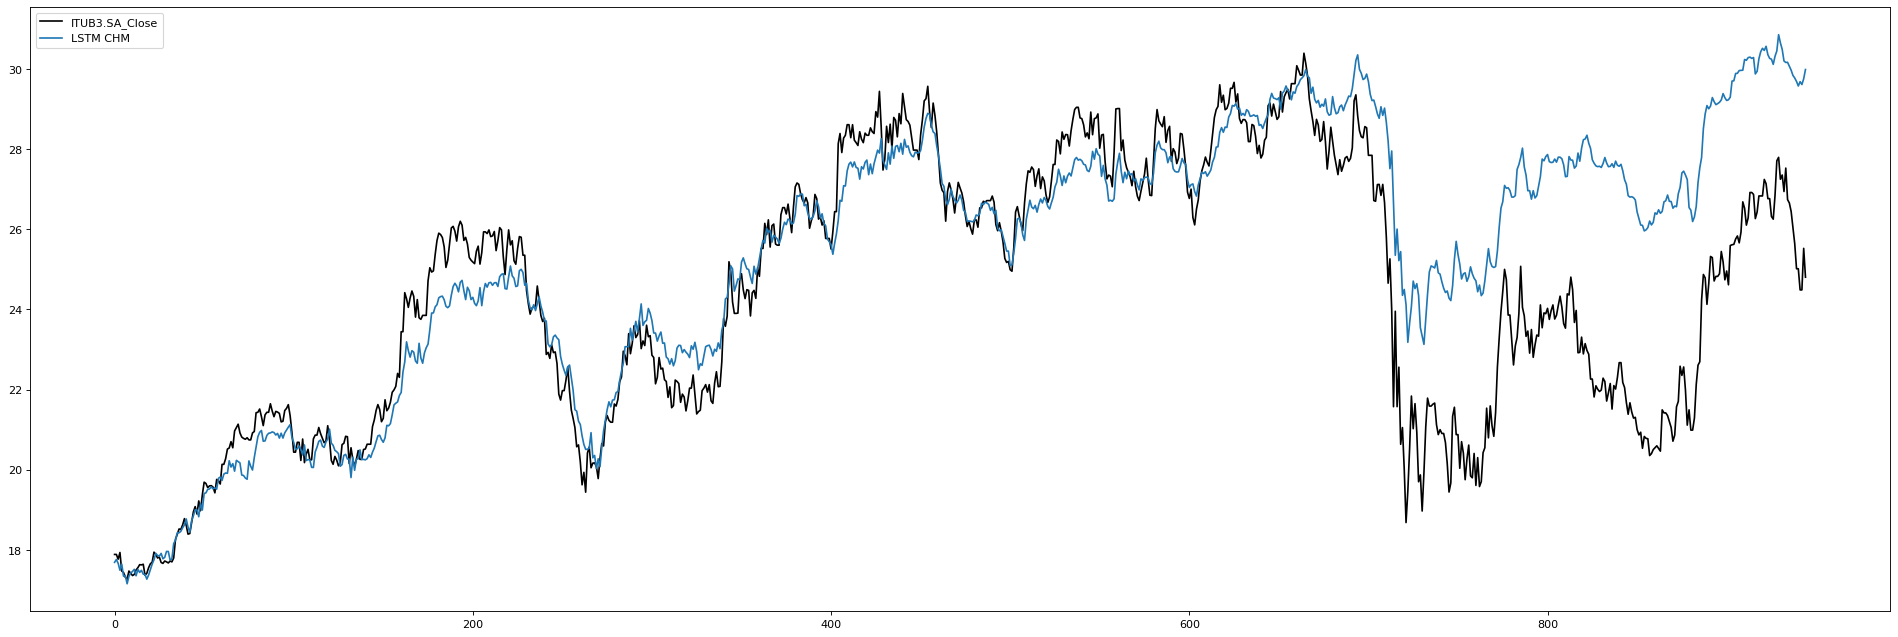

In [7]:
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(ground_truth, label='ITUB3.SA_Close', color='black')
plt.plot(pred_lstm, label='LSTM CHM')
plt.plot(res_pred_norm, label='LSTM')
#plt.plot(pred_norm_esn.predict_generator(test).ravel(), label='ESN')
plt.legend()
plt.show()


# ESN

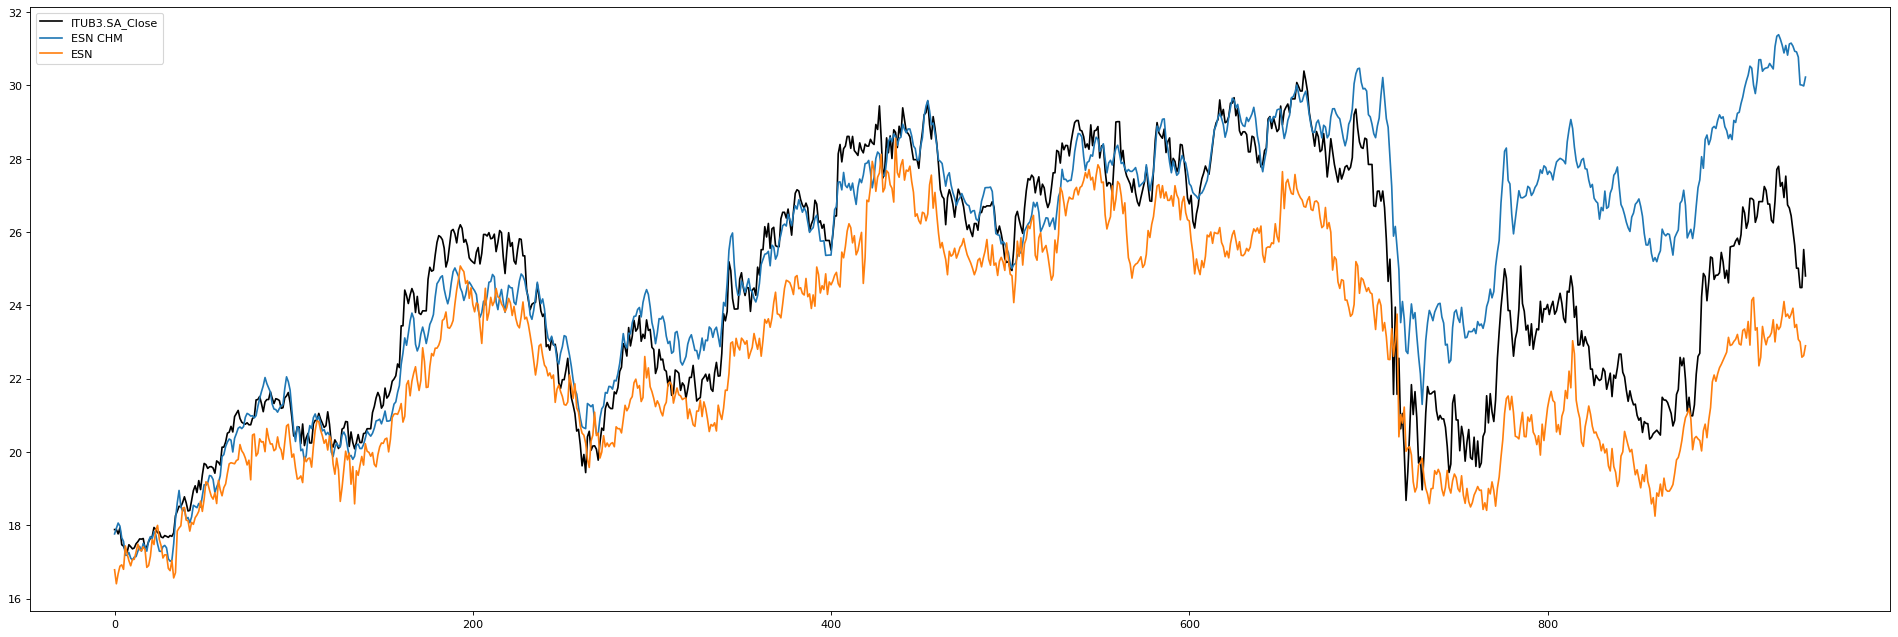

In [22]:
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(ground_truth, label='ITUB3.SA_Close', color='black')
plt.plot(pred, label='ESN CHM')
#plt.plot(pred_norm.predict_generator(test).ravel(), label='LSTM')
plt.plot(res_pred_norm_esn, label='ESN')
plt.legend()
plt.show()


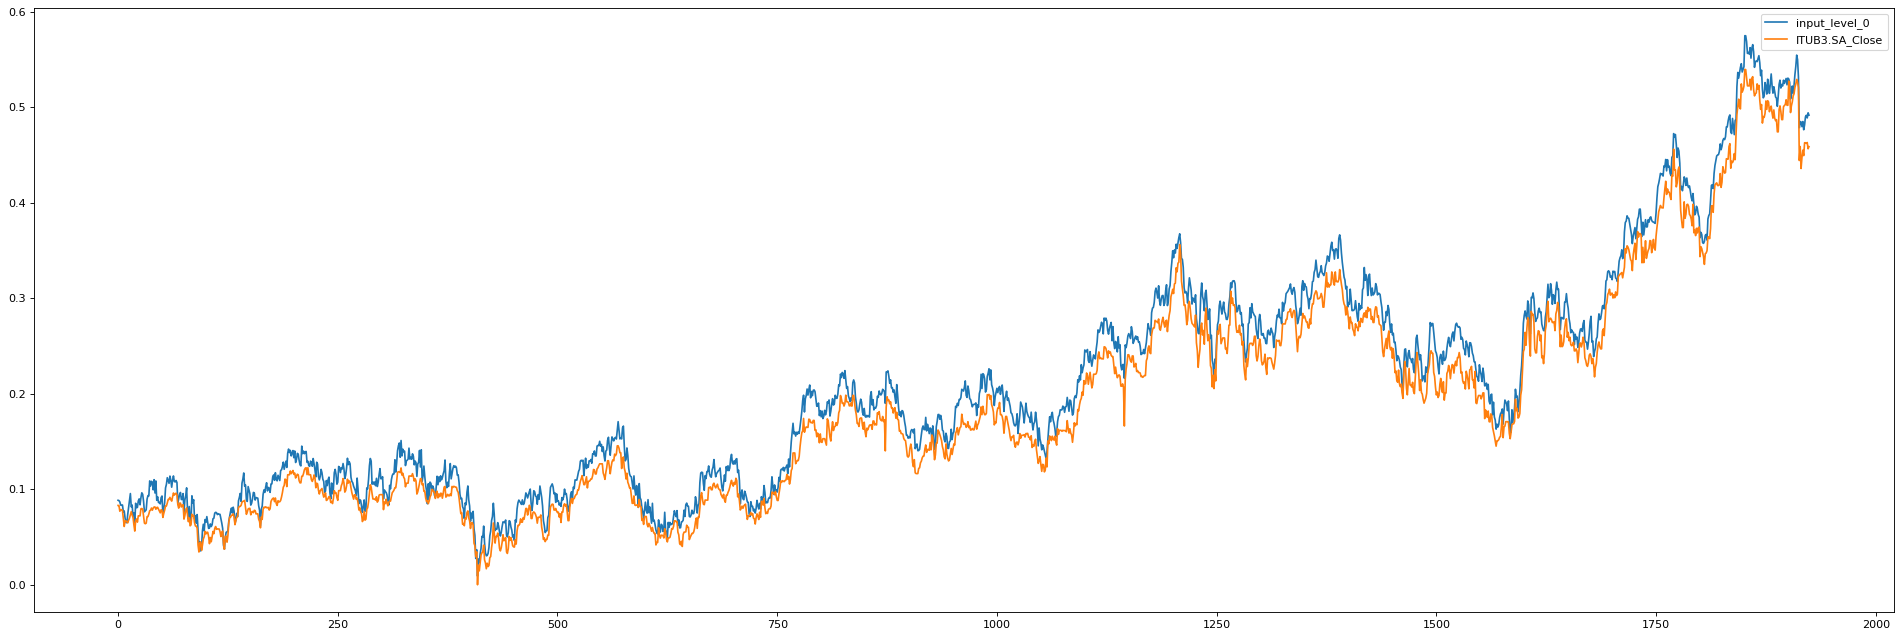

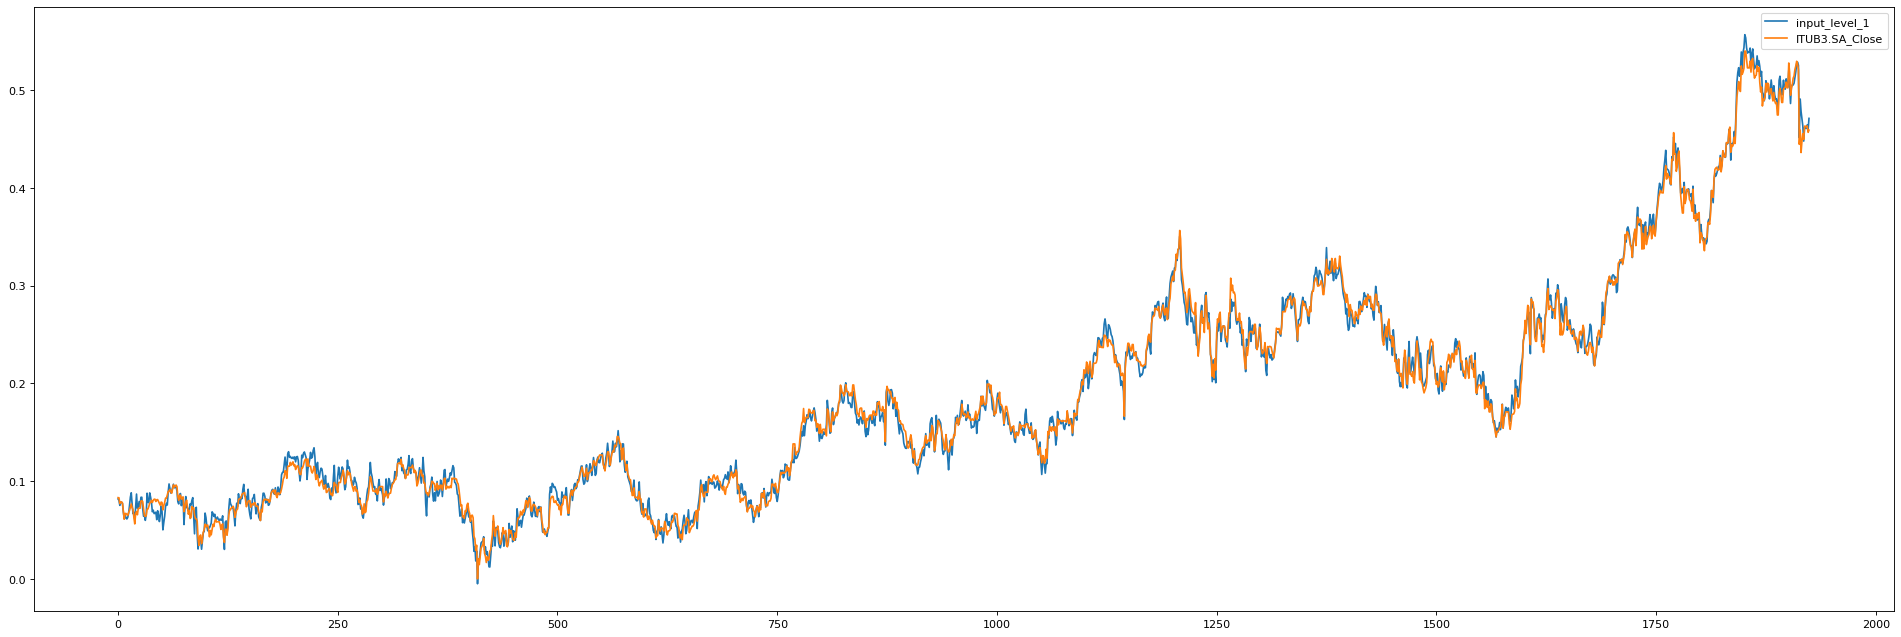

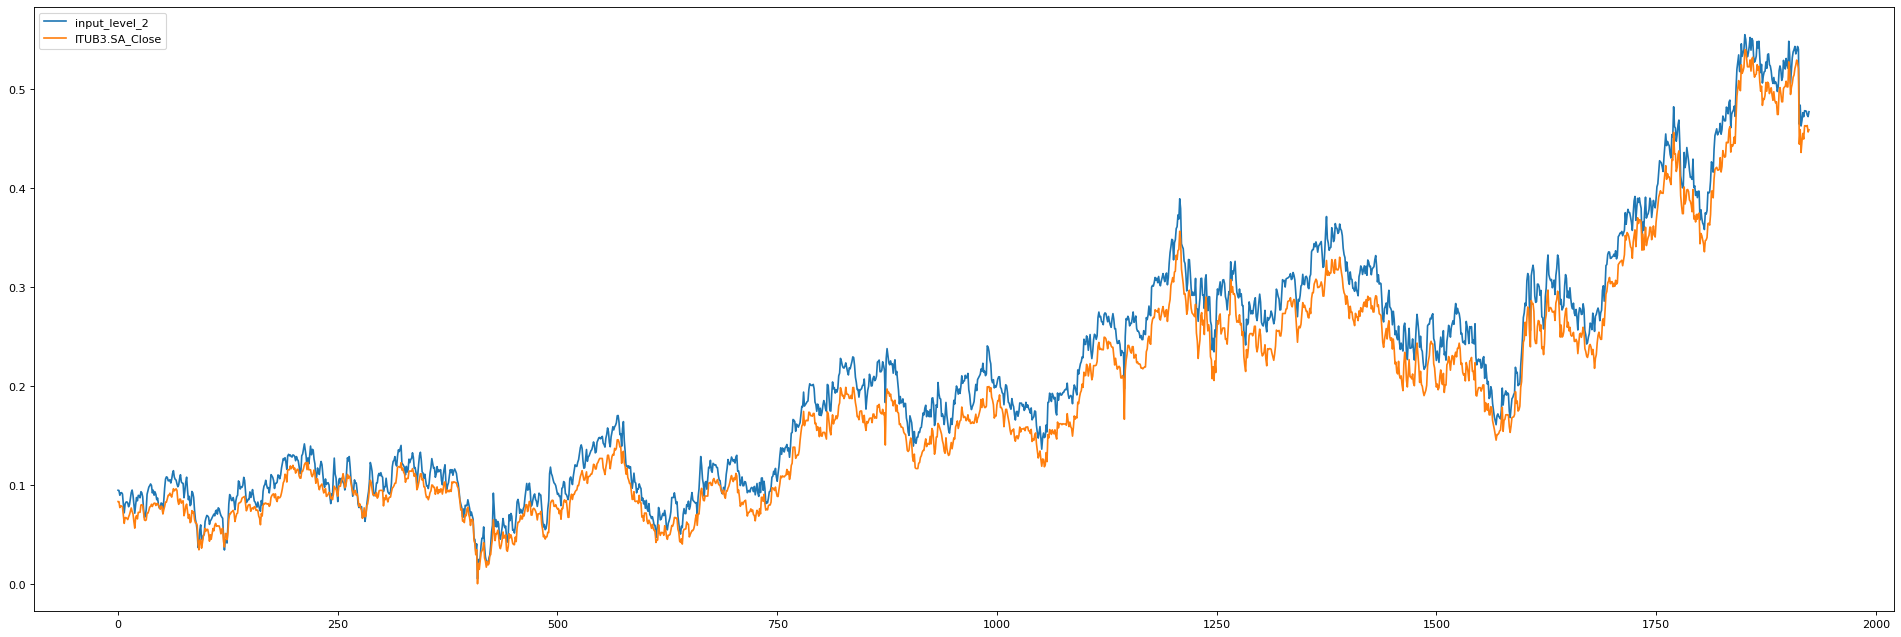

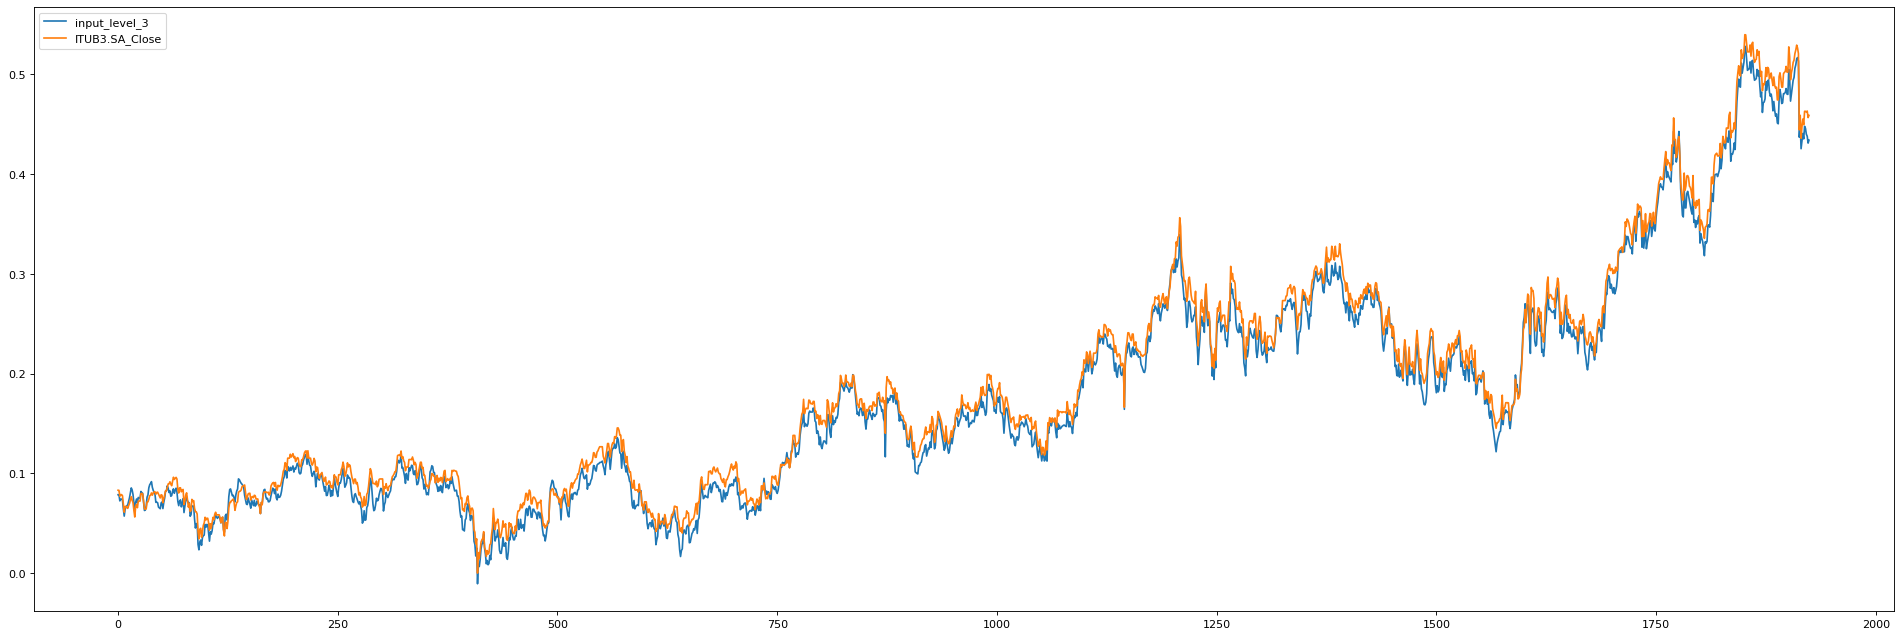

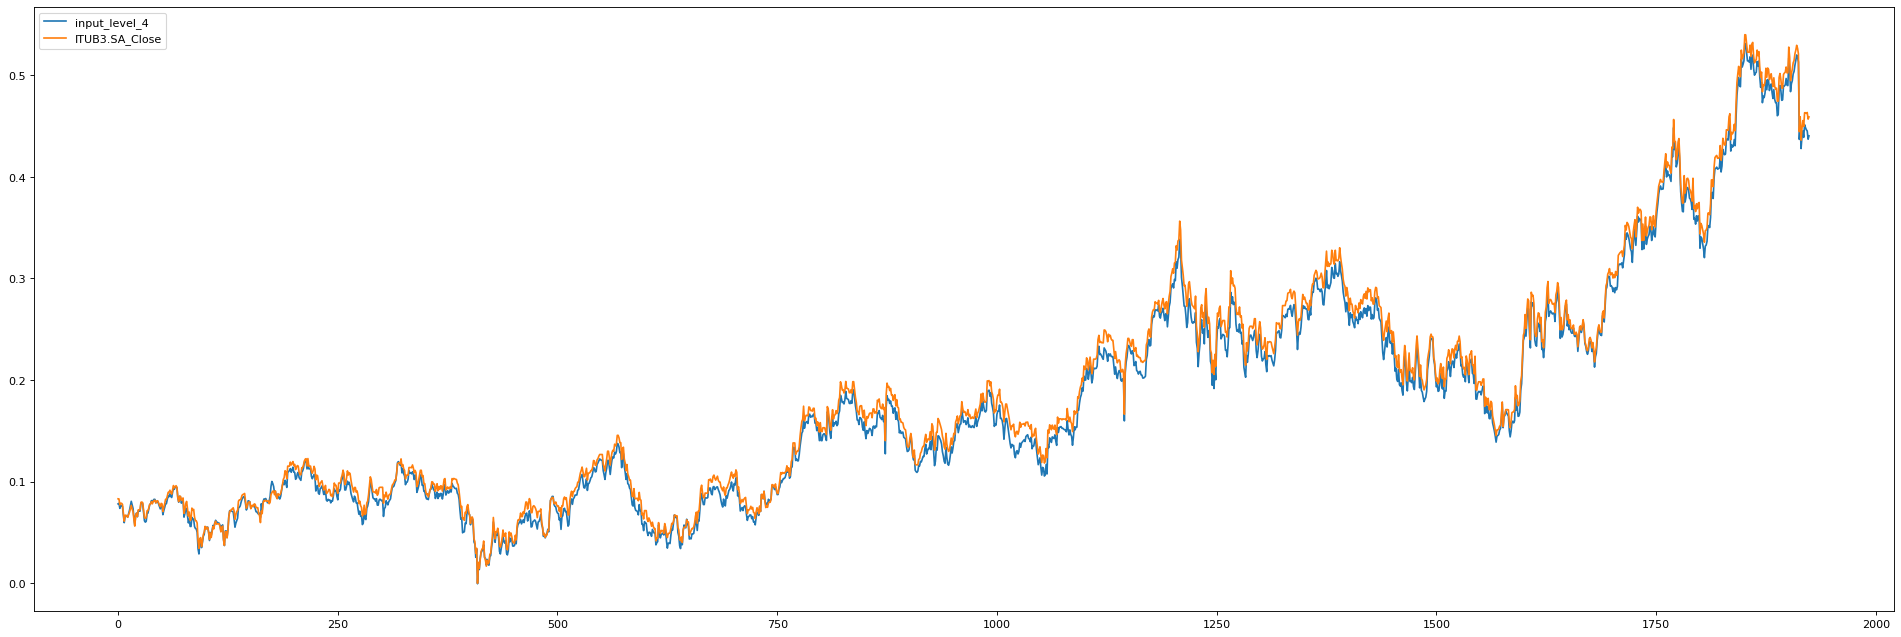

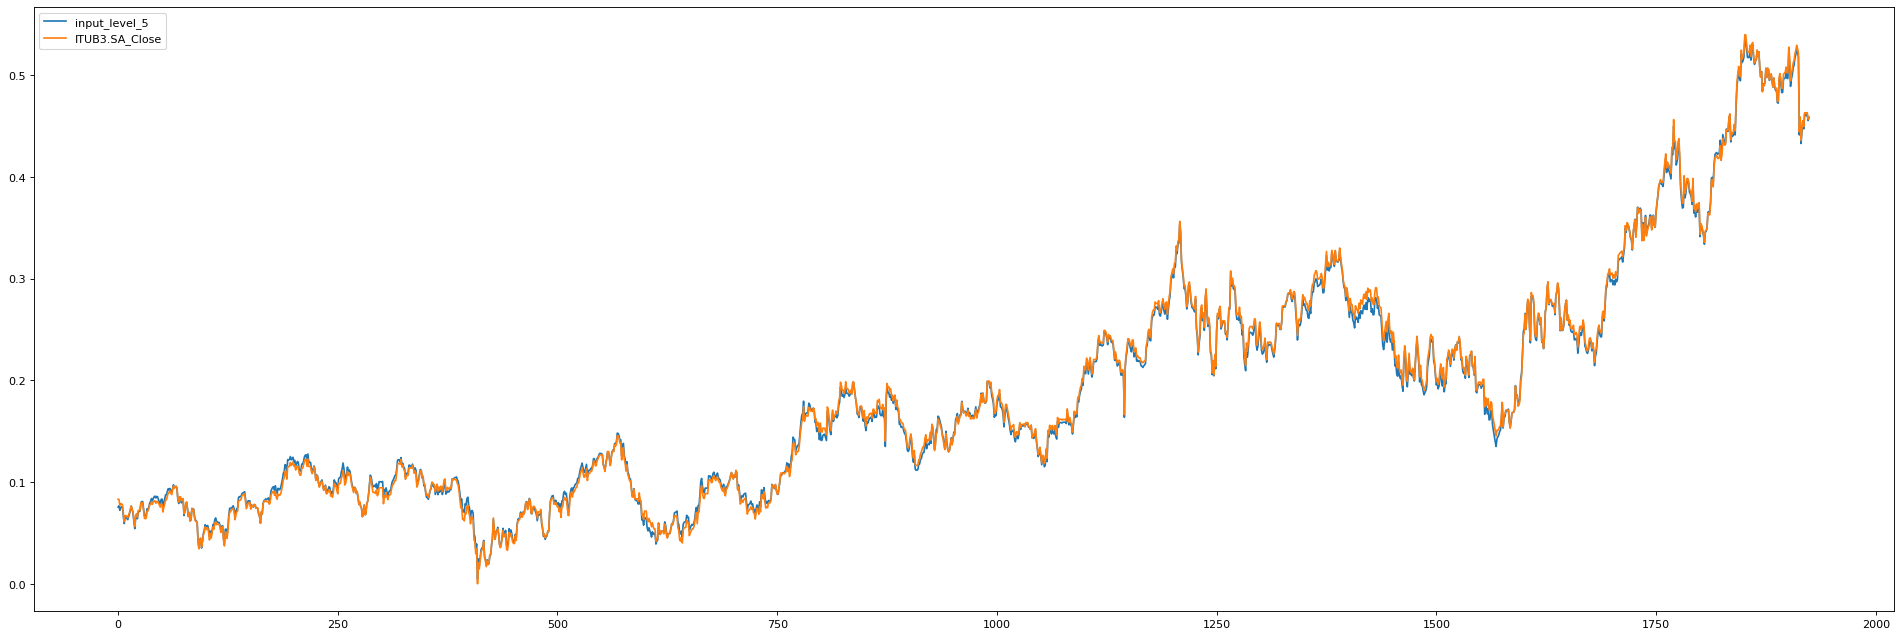

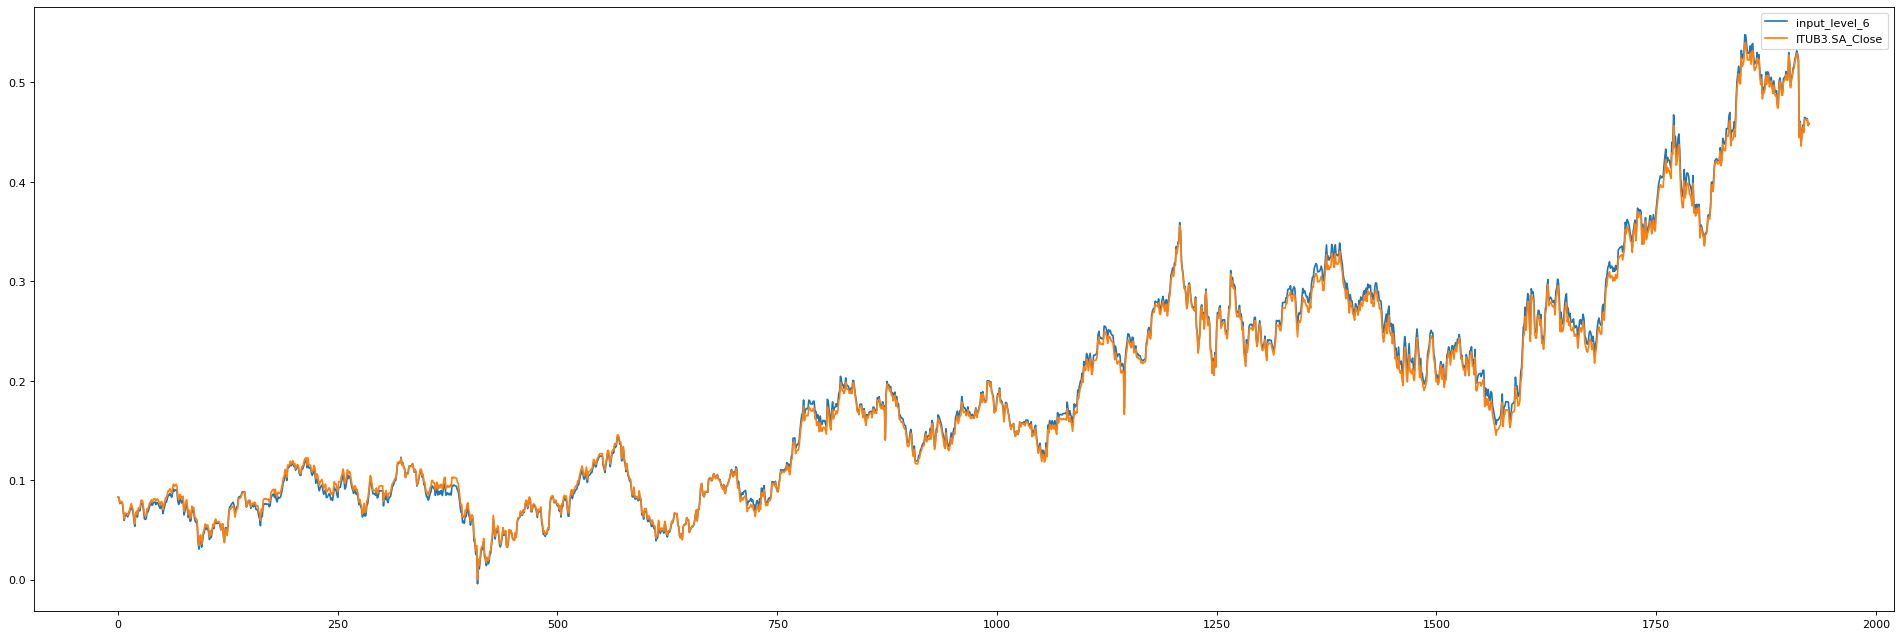

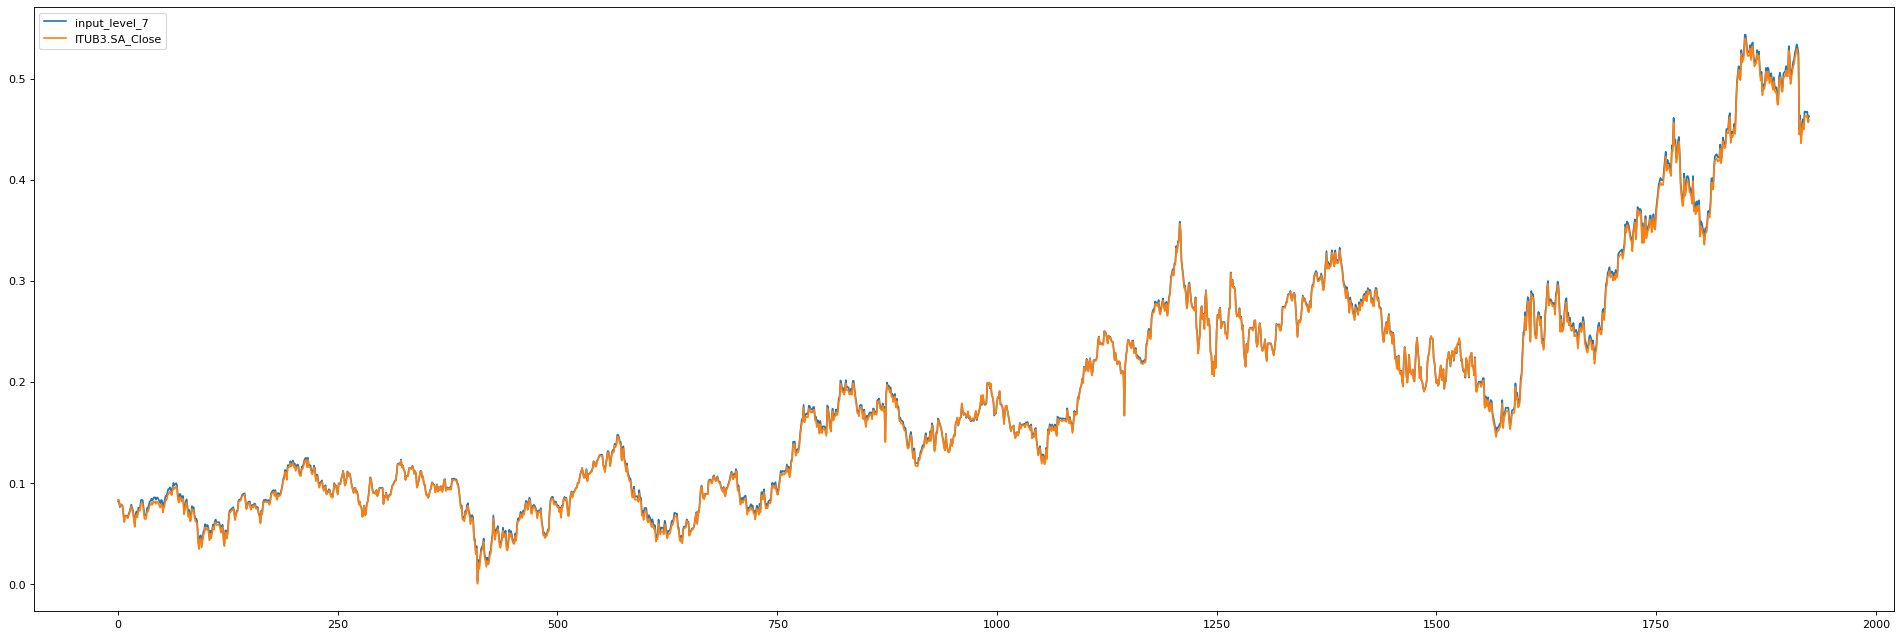

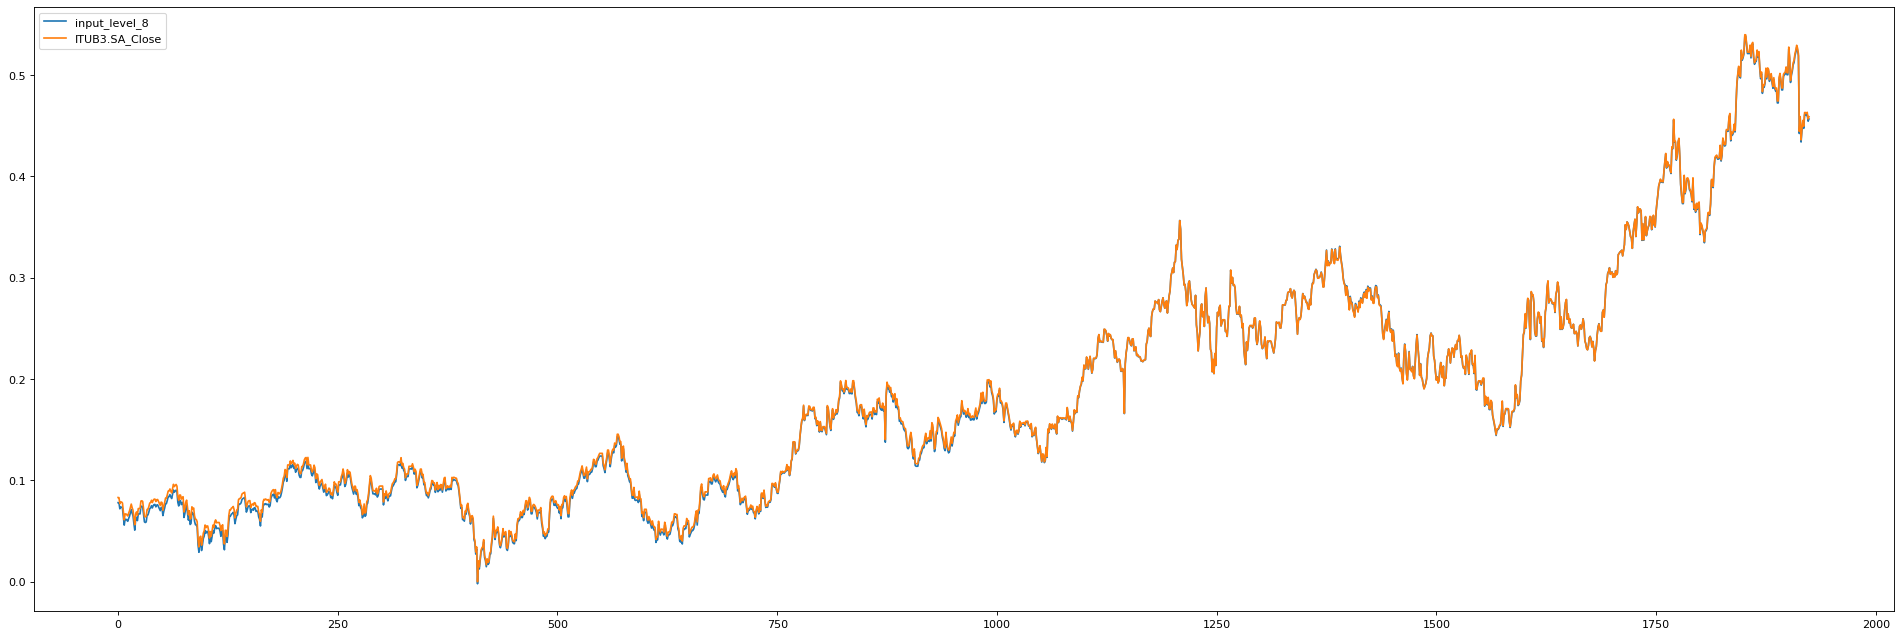

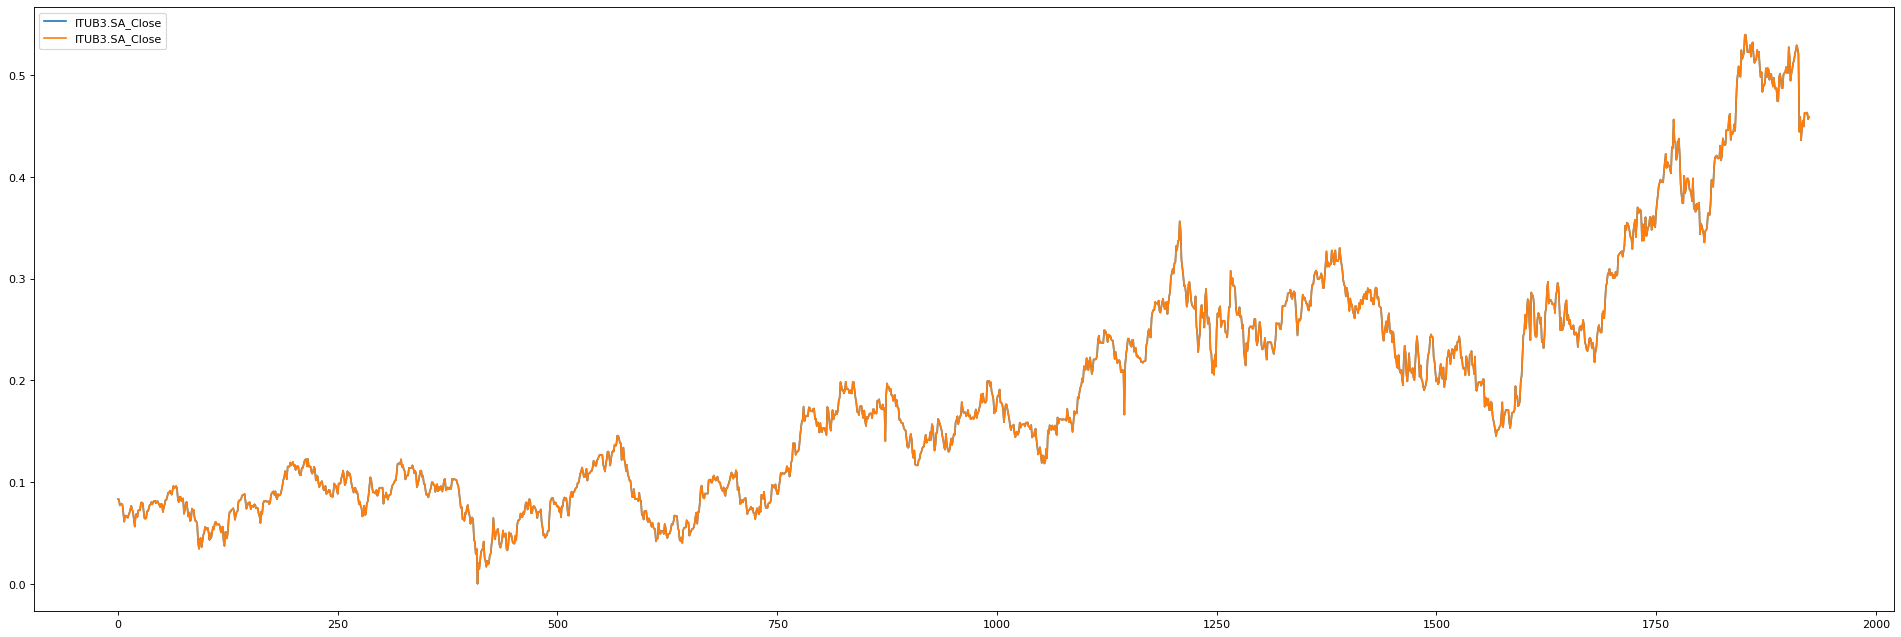

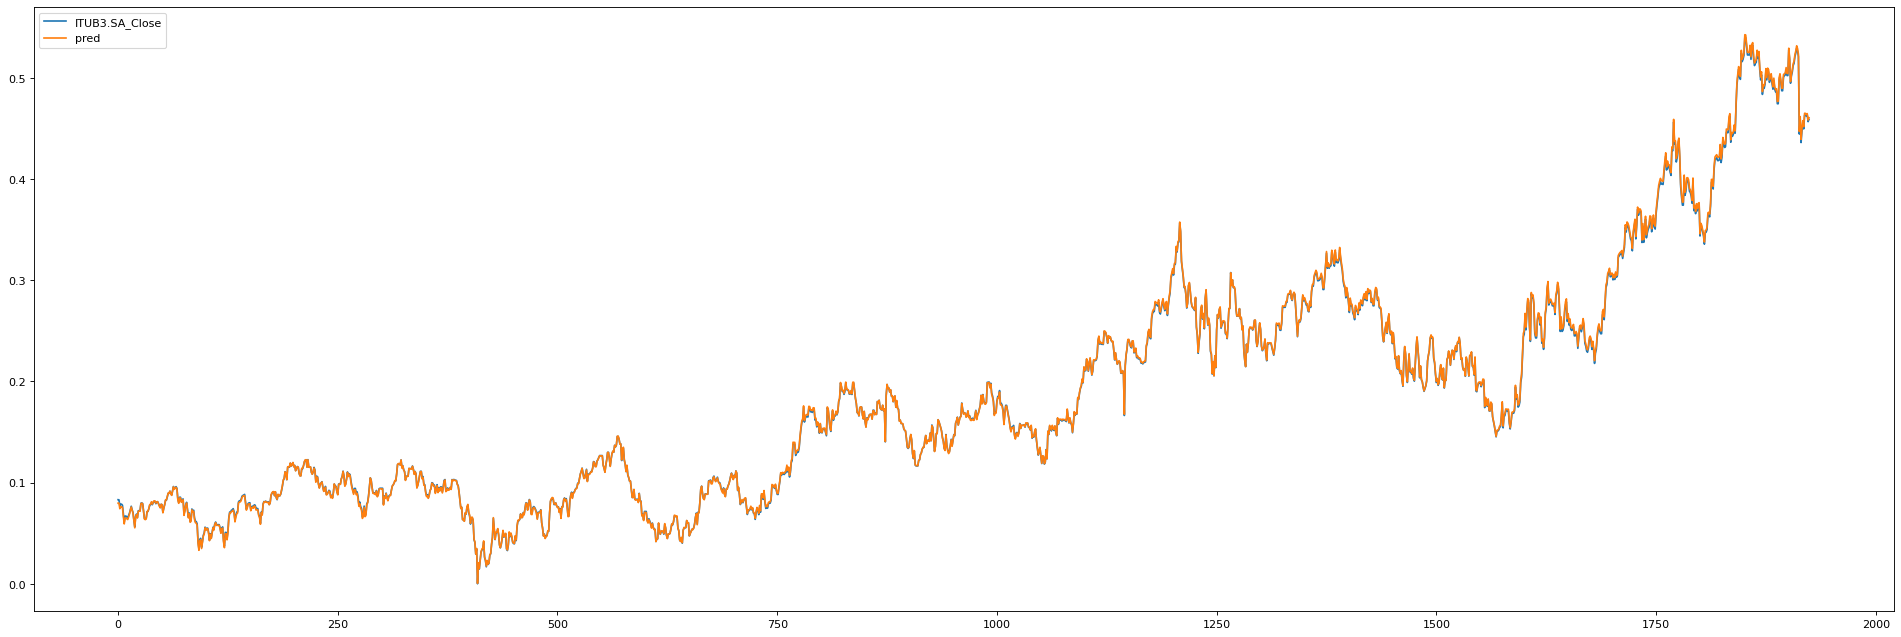

[0.12252654108718941, 0.049623126723233116, 0.12891477741274315, 0.09937456020940758, 0.061936766804643176, 0.02505006774722503, 0.030213825140100358, 0.016885336291968218, 0.022028340477002282]
Model :  0.006824138936448973
Average of Levels :  0.06183926021039026


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape

mape_list = list()

for i in chm._list_stages_bottom_up[0]._regressor.ds.columns:

    plt.figure(figsize=(30, 10), dpi=80)
    mape_list.append(mape(chm._list_stages_bottom_up[0]._regressor.ds[i],chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close']))
    plt.plot(chm._list_stages_bottom_up[0]._regressor.ds[i], label=i)
    plt.plot(chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close'], label='ITUB3.SA_Close')
    plt.legend()
    plt.show()

re = chm._list_stages_bottom_up[0]._regressor
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(re.ds['ITUB3.SA_Close'], label='ITUB3.SA_Close')

pred = re.predict(re.ds[re.x_cols])
plt.plot(pred, label='pred')

plt.legend()
plt.show()
mape_list.pop()
print(mape_list)
print('Model : ',mape(pred ,chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close'][-len(pred):]))
print('Average of Levels : ',sum(mape_list)/len(mape_list))